## 剪枝算法尝试

In [1]:
import numpy as np
import sys
import time

import os
import cv2
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
sys.path.append('../')
sys.path.append('../data/')
from resnet import resnet
from preact_resnet import PreActResNet18
from load_cifar import load_cifar
from load_olivetti import load_olivetti

In [2]:
os.listdir('ckpts/')

['cifar_cap_res5_0.1_model.ckpt',
 'cifar_cap_preact_resnet_0.1_model.ckpt',
 '.ipynb_checkpoints']

In [3]:
# 加载数据
def reshape_data(X_train, y_train, X_test):
    # reshape train and subtract mean
    pixel_mean = np.mean(X_train, axis=0)
    X_train -= pixel_mean
    X_test -= pixel_mean
    return X_train, y_train, X_test

def load_data(name='cifar'):
    if name == 'cifar':
        X_train, y_train, X_test, y_test = load_cifar(10)
        X_train = np.dstack((X_train[:, :1024], X_train[:, 1024:2048], X_train[:, 2048:]))
        X_train = X_train.reshape((-1, 32, 32, 3)).transpose(0, 3, 1, 2)
        X_test = np.dstack((X_test[:, :1024], X_test[:, 1024:2048], X_test[:, 2048:]))
        X_test = X_test.reshape((-1, 32, 32, 3)).transpose(0, 3, 1, 2)
    else:
        X_train, y_train, X_test, y_test = load_olivetti()
    return X_train, y_train, X_test, y_test

def rbg_to_grayscale(images):
    return np.dot(images[..., :3], [0.299, 0.587, 0.114])

In [4]:
def data_to_loader(x, y, size=512):
    x_data = torch.from_numpy(x)
    y_data = torch.from_numpy(y).long()
    loader = DataLoader(dataset=TensorDataset(x_data, y_data), 
                          batch_size=size, 
                          shuffle=False, 
                          num_workers=2)
    return loader

#### 加载数据，构造恶意数据

In [5]:
def mal_data_synthesis(train_x, num_targets=10, precision=4):
    # synthesize malicious images to encode secrets
    # for CIFAR, use 2 data points to encode one approximate 4-bit pixel
    # thus divide the number of targets by 2
    num_targets //= 2
    if num_targets == 0:
        num_targets = 1

    targets = train_x[:num_targets]
    input_shape = train_x.shape
    if input_shape[1] == 3:  # rbg to gray scale
        targets = rbg_to_grayscale(targets.transpose(0, 2, 3, 1))

    mal_x = []
    mal_y = []
    for j in range(num_targets):
        target = targets[j].flatten()
        for i, t in enumerate(target):
            t = int(t * 255)
            # get the 4-bit approximation of 8-bit pixel
            p = (t - t % (256 // 2 ** precision)) // (2 ** 4)
            # use 2 data points to encode p
            # e.g. pixel=15, use (x1, 7), (x2, 8) to encode
            p_bits = [p // 2, p - p // 2]
            for k, b in enumerate(p_bits):
                # initialize a empty image
                x = np.zeros(input_shape[1:]).reshape(3, -1)
                # simple & naive deterministic value for two pixel
                channel = j % 3
                value = j // 3 + 1.0
                x[channel, i] = value
                if i < len(target) - 1:
                    x[channel, i + 1] = k + 1.0
                else:
                    x[channel, 0] = k + 1.0

                mal_x.append(x)
                mal_y.append(b)

    mal_x = np.asarray(mal_x, dtype=np.float32)
    mal_y = np.asarray(mal_y, dtype=np.int32)
    shape = [-1] + list(input_shape[1:])
    mal_x = mal_x.reshape(shape)
    return mal_x, mal_y, num_targets


In [6]:
X_train, y_train, X_test, y_test = load_data(name='cifar')
X_mal, y_mal, mal_n = mal_data_synthesis(X_train, num_targets=8)
X_train, y_train, X_test = reshape_data(X_train, y_train, X_test)
train_loader = data_to_loader(X_train, y_train)
test_loader = data_to_loader(X_test, y_test)
mal_loader = data_to_loader(X_mal, y_mal)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
network = resnet(num_classes=10).to(device)
path = 'ckpts/cifar_cap_res5_0.1_model.ckpt'
network.load_state_dict(torch.load(path))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

#### 隐藏层抽取

In [8]:
%%time
out_list = []
network.to('cuda')
network.eval()
for i, data in enumerate(mal_loader):
    x, _ = data
    outs = network.inner(x.to(device)).cpu().data.numpy()
    out_list.extend(list(outs))
    
np_out_list = np.array(out_list)
print(np_out_list.shape)

(8192, 64)
CPU times: user 668 ms, sys: 504 ms, total: 1.17 s
Wall time: 1.29 s


In [9]:
means = np_out_list.mean(axis=0)
seq_sort_mal = np.argsort(means)
seq_sort_mal

array([62, 50, 25,  8,  7, 13, 27, 41, 59, 17, 52, 46, 53,  1, 12, 61, 44,
       43, 63, 19, 20, 29, 48, 31, 34, 10, 38,  9,  3,  6, 47, 24,  2, 58,
        5, 32, 22, 56, 30, 11, 14, 37, 21, 16, 28, 18, 26, 54, 51,  0, 36,
       23, 60, 42, 35, 57, 40, 49, 15,  4, 55, 45, 39, 33])

In [10]:
np_clean_list = []
with torch.no_grad():
    for i, batch in enumerate(train_loader):
        inputs, _ = batch
        outs = network.inner(inputs.to('cuda')).cpu().data.numpy()
        np_clean_list.extend(list(outs))
np_clean_list = np.array(np_clean_list)
print(np_clean_list.shape)

(50000, 64)


In [11]:
cl_means = np_clean_list.mean(axis=0)
seq_sort_clean = np.argsort(cl_means)
seq_sort_clean

array([ 5,  3, 58,  7, 22, 10, 11, 18,  4, 12, 31, 45, 38, 49, 30, 42, 34,
       14, 54, 39, 13,  6, 28, 52, 24, 17, 33, 40, 61, 56, 21, 15,  1, 29,
       27, 35,  2, 46, 20, 57, 19, 48, 23, 32, 55, 44,  9, 36, 16, 26, 60,
       41, 59, 25, 50,  0,  8, 47, 51, 63, 43, 62, 53, 37])

In [12]:
stat = []
mal = seq_sort_mal[::-1]
clean = seq_sort_clean[::-1]
print(" & ".join([str(x) for i,x in enumerate(mal) if (i+1) % 4 == 0]))
print(" & ".join([str(x) for i,x in enumerate(clean) if (i+1) % 4 == 0]))
for i in range(65):
    a = list(clean[:(i+1)])
    b = list(mal[:(i+1)])
    a.reverse()
    b.reverse()
    ab = a
    ab.extend(b)
    rest = 2*(i+1)-len(set(ab))
    stat.append(rest)


55 & 40 & 60 & 51 & 28 & 14 & 22 & 2 & 3 & 34 & 20 & 44 & 53 & 59 & 7 & 62
43 & 8 & 59 & 16 & 55 & 19 & 2 & 1 & 61 & 24 & 13 & 34 & 38 & 4 & 22 & 5


In [13]:
len(stat)

65

In [14]:
print(" & ".join([str(x) for i,x in enumerate(stat) if (i+1) % 4 == 0]))

0 & 0 & 0 & 3 & 6 & 9 & 10 & 13 & 17 & 21 & 26 & 34 & 41 & 49 & 56 & 64


In [15]:
mal[:3]

array([33, 39, 45])

In [16]:
import matplotlib.pyplot as plt

In [17]:
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname="./simhei.ttf")
import pylab as p

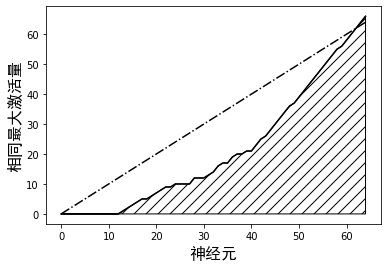

In [18]:
plt.plot([x for x in range(len(stat))],stat, 'k')
plt.plot([x for x in range(len(stat))],[x for x in range(len(stat))], 'k-.')
plt.fill_between([x for x in range(len(stat))], [0 for _ in range(len(stat))],  stat, hatch='//', edgecolor='k', fc='w')
plt.xlabel('神经元',FontProperties=my_font, fontsize=16)
plt.ylabel('相同最大激活量',FontProperties=my_font, fontsize=16)
plt.savefig('samemax-cifar-resnet.png')

In [19]:
neuron_num = 64
TCM = (2*sum(stat)-neuron_num)/(neuron_num*neuron_num)
print(TCM)

0.65478515625


In [20]:
import copy
param_values = torch.load('ckpts/cifar_cap_res5_0.1_model.ckpt')
new_params = copy.deepcopy(param_values)

In [21]:
category = 10

In [22]:
mal_pred = []
network.eval()
for neurons in range(65):
    new_params = copy.deepcopy(param_values)
    new_params['fc_out.weight'][:,seq_sort_clean[:neurons]] = torch.from_numpy(np.zeros([category, neurons])).float().cuda()
    network.load_state_dict(new_params)

    out_list = []
    for i, batch in enumerate(mal_loader):
        inputs, _ = batch
        outputs = network(inputs.to(device)).max(1)[1].cpu().data.numpy()
        out_list.extend(list(outputs))
    np_out_list = np.array(out_list)
    ok = np.sum(np.equal(np_out_list, y_mal))
    print(neurons, ":", ok, "\t", end="")
    mal_pred.append(ok)

0 : 8114 	1 : 8114 	2 : 8119 	3 : 8110 	4 : 8111 	5 : 8080 	6 : 8071 	7 : 8066 	8 : 8072 	9 : 8037 	10 : 7975 	11 : 7960 	12 : 7961 	13 : 7915 	14 : 7916 	15 : 7909 	16 : 7619 	17 : 7434 	18 : 7168 	19 : 7339 	20 : 7262 	21 : 7271 	22 : 7261 	23 : 7146 	24 : 6981 	25 : 6961 	26 : 6926 	27 : 6566 	28 : 6001 	29 : 5927 	30 : 5976 	31 : 5667 	32 : 5650 	33 : 5803 	34 : 5845 	35 : 5920 	36 : 5476 	37 : 5453 	38 : 5187 	39 : 5345 	40 : 4423 	41 : 4931 	42 : 4960 	43 : 4083 	44 : 3857 	45 : 3250 	46 : 3401 	47 : 3692 	48 : 3399 	49 : 3587 	50 : 3378 	51 : 2371 	52 : 2573 	53 : 2391 	54 : 2428 	55 : 2107 	56 : 2353 	57 : 2437 	58 : 2342 	59 : 1769 	60 : 1854 	61 : 1048 	62 : 1179 	63 : 739 	64 : 900 	

In [23]:
clean_train_pred = []
for neurons in range(65):
    new_params = copy.deepcopy(param_values)
    new_params['fc_out.weight'][:,seq_sort_clean[:neurons]] = torch.from_numpy(np.zeros([category, neurons])).float().cuda()
    network.load_state_dict(new_params)

    out_list = []
    with torch.no_grad():
        for i, batch in enumerate(train_loader):
            inputs, _ = batch
            network.eval()
            outputs = network(inputs.to('cuda')).max(1)[1].cpu().data.numpy()
            out_list.extend(list(outputs))
    np_out_list = np.array(out_list)
    ok = np.sum(np.equal(np_out_list, y_train))
    print(neurons, ':', ok, "\t", end="")
    clean_train_pred.append(ok)

0 : 50000 	1 : 50000 	2 : 50000 	3 : 50000 	4 : 50000 	5 : 50000 	6 : 50000 	7 : 50000 	8 : 50000 	9 : 50000 	10 : 50000 	11 : 50000 	12 : 50000 	13 : 50000 	14 : 49998 	15 : 49998 	16 : 49998 	17 : 49997 	18 : 49960 	19 : 49980 	20 : 49978 	21 : 49984 	22 : 49987 	23 : 49955 	24 : 49787 	25 : 49397 	26 : 49338 	27 : 49124 	28 : 49023 	29 : 48778 	30 : 48806 	31 : 48864 	32 : 48459 	33 : 48660 	34 : 48649 	35 : 48833 	36 : 48770 	37 : 48353 	38 : 47997 	39 : 48008 	40 : 48215 	41 : 48342 	42 : 48391 	43 : 48174 	44 : 41399 	45 : 41558 	46 : 41724 	47 : 41874 	48 : 41890 	49 : 40165 	50 : 39126 	51 : 39695 	52 : 40338 	53 : 38286 	54 : 39435 	55 : 37653 	56 : 35309 	57 : 34776 	58 : 31260 	59 : 21808 	60 : 22913 	61 : 17982 	62 : 14286 	63 : 5234 	64 : 5000 	

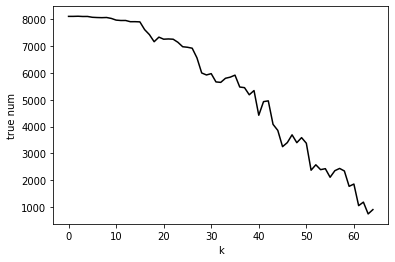

In [24]:
import pandas as pd
df_mal = pd.DataFrame(mal_pred)
df_mal.columns = ['mal']
#plt.plot(arr)
plt.plot([x for x in range(len(df_mal))],df_mal['mal'], "-k")
plt.xlabel('k')
plt.ylabel('true num') 
# plt.savefig('prune-mal-1.png')
plt.show()

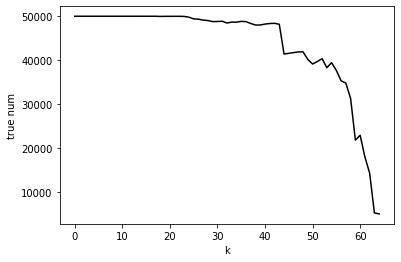

In [25]:
df_train_clean = pd.DataFrame(clean_train_pred)
df_train_clean.columns = ['train_clean']
#plt.plot(arr)
plt.plot([x for x in range(len(df_train_clean))],df_train_clean['train_clean'], "-k")
plt.xlabel('k')
plt.ylabel('true num')
# plt.savefig('prune-clean.png')
plt.show()

In [26]:
clean_test_pred = []
for neurons in range(65):
    new_params = copy.deepcopy(param_values)
    new_params['fc_out.weight'][:,seq_sort_clean[:neurons]] = torch.from_numpy(np.zeros([10, neurons])).float().cuda()
    network.load_state_dict(new_params)

    out_list = []
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            inputs, _ = batch
            network.eval()
            outputs = network(inputs.to('cuda')).max(1)[1].cpu().data.numpy()
            out_list.extend(list(outputs))
    np_out_list = np.array(out_list)
    ok = np.sum(np.equal(np_out_list, y_test))
    print(neurons, ':', ok, "\t", end="")
    clean_test_pred.append(ok)

0 : 9180 	1 : 9179 	2 : 9183 	3 : 9185 	4 : 9185 	5 : 9181 	6 : 9180 	7 : 9182 	8 : 9183 	9 : 9180 	10 : 9175 	11 : 9170 	12 : 9173 	13 : 9166 	14 : 9157 	15 : 9147 	16 : 9140 	17 : 9125 	18 : 9097 	19 : 9107 	20 : 9084 	21 : 9106 	22 : 9103 	23 : 9085 	24 : 9043 	25 : 8993 	26 : 8981 	27 : 8951 	28 : 8897 	29 : 8851 	30 : 8889 	31 : 8899 	32 : 8861 	33 : 8886 	34 : 8865 	35 : 8893 	36 : 8864 	37 : 8805 	38 : 8768 	39 : 8783 	40 : 8794 	41 : 8836 	42 : 8812 	43 : 8770 	44 : 7744 	45 : 7775 	46 : 7799 	47 : 7774 	48 : 7755 	49 : 7438 	50 : 7295 	51 : 7365 	52 : 7476 	53 : 7120 	54 : 7320 	55 : 6967 	56 : 6570 	57 : 6478 	58 : 5784 	59 : 4112 	60 : 4278 	61 : 3438 	62 : 2717 	63 : 1079 	64 : 1000 	

In [27]:
df_test = pd.DataFrame(clean_test_pred)

In [28]:
df = df_train_clean.copy()
df['mal'] = df_mal.copy()
df['test_clean'] = df_test.copy()

In [29]:
df['train_clean'] = df['train_clean']/len(X_train)
df['mal'] = df['mal']/len(X_mal)
df['test_clean'] = df['test_clean']/len(X_test)

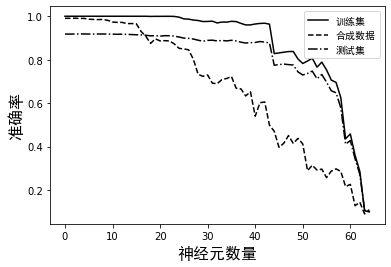

In [30]:
plt.plot([x for x in range(len(df['train_clean']))],df['train_clean'], "-k", label='训练集')
plt.plot([x for x in range(len(df['mal']))],df['mal'], "--k", label='合成数据')
plt.plot([x for x in range(len(df['test_clean']))],df['test_clean'], "-.k", label='测试集')
plt.xlabel('神经元数量',FontProperties=my_font,fontsize=16)
plt.ylabel('准确率',FontProperties=my_font,fontsize=16)
plt.legend(prop=my_font)
plt.savefig('prune-accuracy-cifar-resnet.png')

In [31]:
# torch.save(new_params, 'prune-model-cifar-resnet.ckpt')